# SheCodeAfrica Advanced Machine Learning Project

## Prediction of Rent Prices for Houses in Nigeria

The aim of this project is to
- Extract data from a Nigerian property website(Site used was propertypro.ng)
- Clean, Preprocess and Analyse the data extracted
- Build a machine learning model that predicts house rent price based on some details specifically location, price, number of rooms and bathrooms
- Deploy to a web app using flask

## Web Scraping

importing the needed libraries

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as stats
from sklearn.svm import SVC
import pickle
import warnings
warnings.filterwarnings("ignore")

In [109]:
#Creating a driver
driver=webdriver.Chrome('C:/User/PC/Downloads/chromedriver_win32.exe')

C:\Users\PC\AppData\Local\Temp/ipykernel_5760/687817639.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome('C:/User/PC/Downloads/chromedriver_win32.exe')


There are multiple pages, about 370 so I created a while loop to make it easier extract data from all 370 at once

In [110]:
page = 1
while page != 370:
    url = 'https://www.propertypro.ng/property-for-rent/house/?search=&auto=&bedroom=&min_price=&max_price=&page={page}'
    driver.get(url)
    page = page + 1

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=108.0.5359.125)
Stacktrace:
Backtrace:
	(No symbol) [0x00F8F243]
	(No symbol) [0x00F17FD1]
	(No symbol) [0x00E0D04D]
	(No symbol) [0x00DF2D7A]
	(No symbol) [0x00E5BE7B]
	(No symbol) [0x00E6C196]
	(No symbol) [0x00E58386]
	(No symbol) [0x00E3163C]
	(No symbol) [0x00E3269D]
	GetHandleVerifier [0x01229A22+2655074]
	GetHandleVerifier [0x0121CA24+2601828]
	GetHandleVerifier [0x01038C0A+619850]
	GetHandleVerifier [0x01037830+614768]
	(No symbol) [0x00F205FC]
	(No symbol) [0x00F25968]
	(No symbol) [0x00F25A55]
	(No symbol) [0x00F3051B]
	BaseThreadInitThunk [0x767C00F9+25]
	RtlGetAppContainerNamedObjectPath [0x77B97BBE+286]
	RtlGetAppContainerNamedObjectPath [0x77B97B8E+238]


Created an emply list for the columns I am interested in

In [ ]:
addresses = []
prices = []
details =[]

In [ ]:
page = 1
while page != 370:
    url = 'https://www.propertypro.ng/property-for-rent/house/?search=&auto=&bedroom=&min_price=&max_price=&page={page}'
    response = requests.get(url)
    html = response.content
    soup = bs(html, "lxml")
    for element in soup.findAll('div', attrs={'class': 'single-room-sale'}):
        address = element.find('div', attrs={'class': 'single-room-text'})
        price = element.find('div', attrs={'class':'n50'})
        detail = element.find('div', attrs={'class': 'fur-areea'})
        
        if address and address.text:
            addresses.append(address.text)
        else:
            addresses.append('No display data')
        
        if price and price.text:
            prices.append(price.text)
        else:
            prices.append('No display data')
        
        if detail and detail.text:
            details.append(detail.text)
        else:
            details.append('No display data')
            
    page = page + 1

In [ ]:
addresses = []
prices = []
details =[]

Created a soup to extract the data, then an if statement so empty data does not return error while the scraper is parsing the site

In [ ]:
content = driver.page_source
soup = BeautifulSoup(content, features='html.parser')
for element in soup.findAll('div', attrs={'class': 'single-room-sale'}):
    address = element.find('div', attrs={'class': 'single-room-text'})
    price = element.find('div', attrs={'class':'n50'})
    detail = element.find('div', attrs={'class': 'fur-areea'})
    
    if address and address.text:
        addresses.append(address.text)
    else:
        addresses.append('No display data')

    if price and price.text:
        prices.append(price.text)
    else:
        prices.append('No display data')
        
    if detail and detail.text:
        details.append(detail.text)
    else:
        details.append('No display data')
        

Created a dataframe with the lists generated earlier, then saved it to a file

In [ ]:
df = pd.DataFrame({'Address': addresses, 'Price': prices, 'Details': details})
df.to_csv('listings.csv', index=False, encoding='utf-8')

Checking the shape of the dataframe to know how much data was extracted

In [ ]:
df.shape

## Data Cleaning

importing the csv file to start analysis

In [ ]:
listings = pd.read_csv('listings.csv')

In [ ]:
listings.head()

Stripping to just town and state

In [ ]:
listings['State']=listings['Address'].str[25:40]

In [ ]:
listings.head()

I realised, while cleaning, the extreme lack of uniformity in the way the Address was written and found no alternative for segregating location on the website or through code due to the large number and difference in entries.

Also, Over 40%  of the data from the site are on a particular town in a state - Lekki Lagos, Nigeria. The remaining 60% shared by hundreds of towns in 20 states, resulting in a skewed data. 

I decided to remove the  Address column. However, considering the importance of location on house rent prices and the wide variability between house prices in different locations especially since the data scraped is of 20 states in Nigeria.

To solve these, I decided to scrape only the data from a particular town and state, thereby removing the effect of variability in location since all the house prices will be from that location.

I choosed the location with the highest number of entries. As a result, the model will predict house prices in Lekki, Lagos, Nigeria

### Scraping data for house rent prices in Lekki Lagos, Nigeria

Creating a while loop to extract the 142 pages of data

In [ ]:
amount = []
qualities =[]

In [ ]:
page = 1
while page != 142:
    url = 'https://www.propertypro.ng/property-for-rent/house/in/lagos/lekki?page={page}'
    response = requests.get(url)
    html = response.content
    soup = bs(html, "lxml")
    for element in soup.findAll('div', attrs={'class': 'single-room-sale'}):
        price = element.find('div', attrs={'class':'n50'})
        detail = element.find('div', attrs={'class': 'fur-areea'})
        
        if price and price.text:
            amount.append(price.text)
        else:
            amount.append('NaN')
        
        if detail and detail.text:
            qualities.append(detail.text)
        else:
            qualities.append('NaN')
            
    page = page + 1

Created a dataframe with the lists generated earlier, then saved it to a file

In [ ]:
df2 = pd.DataFrame({'Price': amount, 'Details': qualities})

In [ ]:
df2.to_csv('lagos-listing.csv', index=False, encoding='utf-8')

Checking the shape of the dataframe to know how much data was extracted

In [ ]:
df2.shape

In [ ]:
df2.head()

In [735]:
listing=pd.read_csv('lagos-listing.csv')

In [736]:
listing.head()

,Price,Details
0,"\n ₦ 4,000,000/year \nSponsored\n",\n4 beds\n4 baths\n5 Toilets\n
1,"\n ₦ 5,000,000 \nPremium Gold\n",\n4 beds\n4 baths\n5 Toilets\n
2,"\n ₦ 7,500,000 \nPremium Gold\n",\n5 beds\n5 baths\n6 Toilets\n
3,"\n ₦ 7,000,000 \nPremium Gold\n",\n5 beds\n5 baths\n6 Toilets\n
4,"\n ₦ 2,700,000 \nPremium Gold\n",\n2 beds\n2 baths\n3 Toilets\n


In [737]:
listing['Price']=listing['Price'].str.strip()

In [738]:
listing['Price']=listing['Price'].str.strip('₦')

In [739]:
listing['Price']=listing['Price'].str.split(' ').str[1]

In [740]:
listing['Price']=listing['Price'].str.replace(',','')
listing['Price']=listing['Price'].str.strip('/year')
listing['Price']=listing['Price'].str.strip('/sqm')

In [741]:
listing.head()

,Price,Details
0,4000000,\n4 beds\n4 baths\n5 Toilets\n
1,5000000,\n4 beds\n4 baths\n5 Toilets\n
2,7500000,\n5 beds\n5 baths\n6 Toilets\n
3,7000000,\n5 beds\n5 baths\n6 Toilets\n
4,2700000,\n2 beds\n2 baths\n3 Toilets\n


In [742]:
listing['Beds']=listing['Details'].str[1]
listing['Baths']=listing['Details'].str[8]
listing['Toilets']=listing['Details'].str[16]

In [743]:
listing.head()

,Price,Details,Beds,Baths,Toilets
0,4000000,\n4 beds\n4 baths\n5 Toilets\n,4,4,5
1,5000000,\n4 beds\n4 baths\n5 Toilets\n,4,4,5
2,7500000,\n5 beds\n5 baths\n6 Toilets\n,5,5,6
3,7000000,\n5 beds\n5 baths\n6 Toilets\n,5,5,6
4,2700000,\n2 beds\n2 baths\n3 Toilets\n,2,2,3


In [744]:
listing=listing.drop(['Details'],axis='columns')

In [745]:
listing.head()

,Price,Beds,Baths,Toilets
0,4000000,4,4,5
1,5000000,4,4,5
2,7500000,5,5,6
3,7000000,5,5,6
4,2700000,2,2,3


Dealing with null values

In [746]:
#Checking for null values
listing.isnull().sum()

Price      141
Beds       141
Baths      141
Toilets    141
dtype: int64

In [747]:
#filling the nulls forward
listing=listing.fillna(method='ffill')
listing.isnull().sum()

Price      0
Beds       0
Baths      0
Toilets    0
dtype: int64

Correcting the data types

In [748]:
listing['Beds']=pd.to_numeric(listing['Beds'], errors='coerce').apply(np.round).astype('Int64')
listing['Beds'].value_counts()

4    2423
5     449
2     307
3      29
0      18
1       6
6       5
Name: Beds, dtype: Int64

In [749]:
listing['Price']=pd.to_numeric(listing['Price'], errors='coerce').apply(np.round).astype('Int64')
listing['Price'].value_counts()

8000000      564
4500000      423
6000000      423
9000000      284
5000000      282
            ... 
1500000        1
47000000       1
800000         1
158000000      1
43000000       1
Name: Price, Length: 79, dtype: Int64

In [750]:
listing['Baths']=pd.to_numeric(listing['Baths'], errors='coerce').apply(np.round).astype('Int64')
listing['Baths'].value_counts()

4    2327
5     543
2     307
0      26
3      21
6       7
1       1
Name: Baths, dtype: Int64

In [751]:
listing['Toilets']=pd.to_numeric(listing['Toilets'], errors='coerce').apply(np.round).astype('Int64')
listing['Toilets'].value_counts()

5    2185
6     542
3     307
4     164
0      26
2       5
7       3
Name: Toilets, dtype: Int64

In [752]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243 entries, 0 to 3242
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Price    3243 non-null   Int64
 1   Beds     3237 non-null   Int64
 2   Baths    3232 non-null   Int64
 3   Toilets  3232 non-null   Int64
dtypes: Int64(4)
memory usage: 114.1 KB


#### Saving the cleaned data in a new file

In [753]:
listing.to_csv('Cleaned-listing.csv', index=False, encoding='utf-8')

## Exploratory Data Analysis (EDA)

In [3]:
listing=pd.read_csv('Cleaned-listing.csv')

In [4]:
listing=listing.fillna(method='ffill')
listing.isnull().sum()

Price      0
Beds       0
Baths      0
Toilets    0
dtype: int64

In [5]:
listing.describe()

,Price,Beds,Baths,Toilets
count,3.243000e+03,3243.00000,3243.000000,3243.000000
mean,3.184007e+07,3.91551,3.942954,4.884366
std,3.156811e+08,0.79419,0.830192,0.895123
min,7.500000e+02,0.00000,0.000000,0.000000
25%,5.000000e+06,4.00000,4.000000,5.000000
50%,6.500000e+06,4.00000,4.000000,5.000000
75%,8.000000e+06,4.00000,4.000000,5.000000
max,1.200000e+10,6.00000,6.000000,7.000000


The Mean and Standard Deviation shows the presence of outliers in the Price column

#### Dealing With Outliers

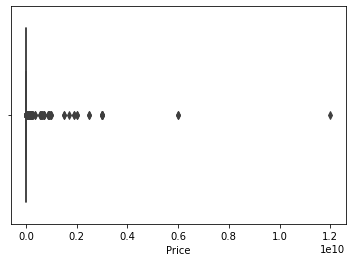

In [6]:
sns.boxplot(x=listing['Price']);

The boxplot confirms the presence of outliers

In [7]:
Q1 = Q3 = np.percentile(listing['Price'], 75, interpolation = 'midpoint')
Q3 = np.percentile(listing['Price'], 75, interpolation = 'midpoint')
IQR = Q3-Q1

In [8]:
lower_bound= np.where(listing['Price']  <= (Q1 - 1.5 * IQR))
upper_bound= np.where(listing['Price'] >= (Q3 + 1.5 * IQR))

In [9]:
upper = np.where(listing['Price'] > 9000000)
lower = np.where(listing['Price'] < 2000000)

In [10]:
listing = listing.drop(upper[0])
listing = listing.drop(lower[0])

In [11]:
listing.shape

(3113, 4)

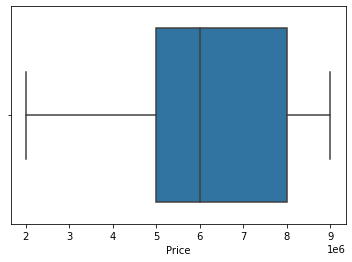

In [12]:
sns.boxplot(x=listing['Price']);

In [13]:
listing.corr()

,Price,Beds,Baths,Toilets
Price,1.000000,0.480090,0.428837,0.321045
Beds,0.480090,1.000000,0.972214,0.933806
Baths,0.428837,0.972214,1.000000,0.962310
Toilets,0.321045,0.933806,0.962310,1.000000


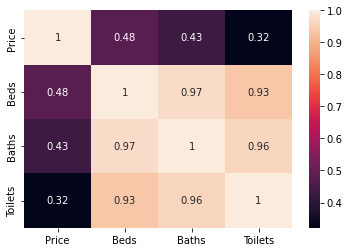

In [14]:
sns.heatmap(listing.corr(), annot = True);

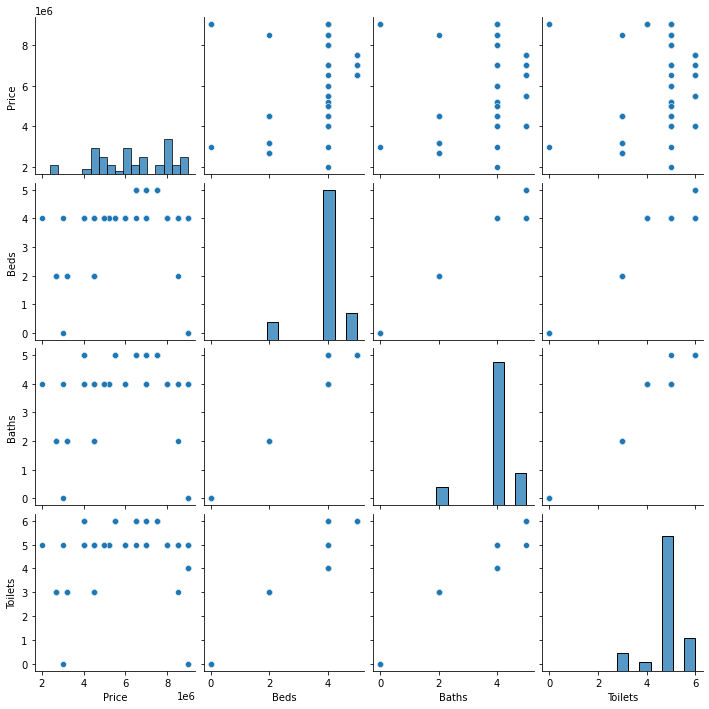

In [15]:
sns.pairplot(listing);

#### Test Train Split

In [16]:
Y = listing.Price
X = listing.drop(columns=['Price'])

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=99)

In [26]:
model = LinearRegression()  
model.fit(X_train, Y_train)

LinearRegression()

In [27]:
y_pred = model.predict(X_test)

In [21]:
from sklearn.metrics import mean_squared_error
print('mean_squared_error is==',mean_squared_error(Y_test,y_pred))
print('root_mean_squared error of is==',np.sqrt(mean_squared_error(Y_test,y_pred)))

mean_squared_error is== 1874407954946.1934
root_mean_squared error of is== 1369090.1924074225


In [28]:
pickle.dump(model,open('model.pkl','wb'))

In [30]:
print(model.predict([[5,5,5]]))

[10209832.62771654]
